# "What is the effect of flipped classroom groups on grades?"
> "We explore the possible effects of student groups on final grades. For this we implement hypothesis tests from three different paradigms: the permutation test, a semi-parametric bootstrap test, and ANOVA. As part of the analysis we compare the different tests through simulation."
- toc: True

The Covid pandemic arrived in the US while I was a visiting professor at Lehigh University. Like many, we had to quickly adapt to a rapidly evolving situation and transition from a physical classroom one week to a fully virtual format the next. To capitalize on the situation, I implemented a flipped classroom with prerecorded lectures. This entailed the students working together on exercises over Zoom divided into breakout rooms. The breakout room groups were created at random for fairness and retained throughout the whole semester. The main rationale for not changing the groups is that the students needed time to get to know each other and figure out a team-based work flow (students in each group had to prepare shared answers on OneNote). However, the downside was that some groups worked together better than others.

This brings me to the central question motivating this notebook: Does the group each student was (randomly) assigned to make a noticeable difference to that student's final grade? More precisely, can we detect a statistically significant difference between the grade distributions of the groups?

This is a classic hypothesis testing question: Assuming the groups make no difference at all to the student grades (this assumption is called the *null hypothesis*), how extreme is the observed data (according to some specified measure called the *statistic*)? If the data is sufficiently extreme, it might be better explained by an *alternative hypothesis*, in this case that there actually *is* some difference in the grade distributions between the groups.

A more general null hypothesis would be that the group means are equal, even if the distributions might differ in other ways. In terms of the grades, testing this hypothesis corresponds to the question: Do the groups have an effect on the *expected* grade of a student (i.e. the group mean that student is a part of)?

We will use three different models belonging to three different paradigms: *nonparametric*, *semiparametric*, and *parametric*:
- **Permutation test:** This test makes no assumptions on the shape of the probability distributions underlying the data in each group. However, the null hypothesis in this case is very broad (or weak): there is no difference at all between the groups, i.e. all grades come from the same distribution (which is unknown and we make no assumptions on). For instance, the null hypothesis does not include the case in which all groups have normal distributions with the same mean but different variances. That said, the statistic we are using is mostly sensitive to differences in means.
- **Semiparametric bootstrap:** In this case we do make a few assumptions on the grade distributions in each group, but they are quite minimal. To put it simply, we assume that all the group distributions have the same "shape" but allow them to have different means and variances. Crucially, we do not make any assumptions on the "distribution shape", which is instead approximated by bootstrap resampling. The null hypothesis in this case is more narrow: there is no difference in the means of the groups, i.e. the underlying grade distributions have the same mean but could have different variances.
- **F-test (One-way ANOVA):** This is probably the most commonly used hypothesis test for comparing group means. It requires the strongest assumptions, but it comes with a narrow null hypothesis (the same as the bootstrap) and has higher power than the boostrap method (we will see later that the bootstrap method has low power due to the small group sizes). The assumptions will be explained further bellow, but basically the data is assumed to be normal with equal variances. We will also use the **Welch F-test**, which corrects for some deviations from these assumptions.

## Outline

This exposition is organized into the following parts:

- **Preamble:** We load the grades and save in a dictionary of named tuples, each containing the final grade and group membership of one section. (I taught three sections of the same course.)
- **Implementation of the Tests:** We motivate the three tests mentioned above and write functions which compute the p-values for each test. We implement the first two from scratch and write a wrapper for the F-test provided by `statsmodels`. We implement the permutations and bootstrap in a **vectorized** manner which makes them **much faster** than the library implementations we found, which are implemented using **for loops**.
- **Data Exploration:** We visualize the data and test it for normality and heteroscedasticity. The data does not appear to be normal and it has a left skew consistent with an article cited below. We also have a look at the empirical distribution of the residuals used in the semiparametric bootstrap. That distribution does not appear to be a good approximation for the actual underlying grades distribution, which might explain the low power of the semiparametric bootstrap.
- **Compute p-values:** We compute the p-values for our data.
- **Discussion:** Discuss the results, considering issues like **multiple comparisons** and the **power** of the tests.
- **Takeaways**
- **Simulations (APPENDIX):** We approximate the **power** and **size** of the hypothesis tests with synthetic data. Specifically, we consider several realistic distributions underlying the grades and study the distribution of the p-values in each scenario.

## Preamble

In [1]:
#collapse-hide
from collections import namedtuple, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.oneway  import anova_oneway as statsmodels_ftest
from tqdm.notebook import tqdm
%matplotlib inline

First we load the grades. There are three sections, all of the same course. Each section has about 10 groups of around 4 students each.

Some groups have 5 students to limit the number of groups per section. There are several groups which had only 3 students by the end of the semester for two reasons. Firstly, some students dropped the course at some point during the semester. Also, after the semester had already started, I created a new group for students who had to remain in Asia because of travel restrictions. This group met at a different time due to their timezone. That group was excluded from this analysis so as not to interfere with the randomization principle.

In a separate notebook we already computed the final grades for all three sections, after extracting the homework and exam grades from a CSV exported from GradeScope (the platform we used for online submission and grading). In that same notebook we changed the group numbers and the section numbers for anonymity, before saving the final grades (together with the renamed sections and groups) in 'anonymized_grades.csv'.

Here we load that CSV file and save the grades in a dictionary, where each item corresponds to a section. The grades and group sizes are stored in a **named tuple**.

In [2]:
all_grades = pd.read_csv('data/anonymized_grades.csv', usecols=['Section', 'Group', 'Percentage'])

GradesWithGroups = namedtuple('GradesWithGroups', ['grades', 'group_sizes'])

section = {}
for n in [1, 2, 3]:
    this_section = all_grades[all_grades['Section'] == f'Section {n}'].sort_values(by=['Group'])
    grades = this_section['Percentage'].to_numpy()
    group_sizes = this_section['Group'].value_counts(sort=False).to_numpy()
    section[n] = GradesWithGroups(grades, group_sizes)

## Implementation of the Tests

### Permutation Test

The permutation test starts with a simple idea: *Assuming* it is the case that the student groups make no difference at all to the final grades, then those groups are essentially arbitrary. We call this assumption the **null hypothesis**. To estimate how unlikely our "observed" grades would be under the null hypothesis (that groups have no influence on grades), we repeatedly split the students into random groups (of the appropriate sizes): This allows us to estimate how *extreme* the differences in grades between the actual groups are relative to the differences in means between the random splits (we will see how to quantify the difference between the groups in a moment). Because under the null hypothesis each split is equally likely, the more extreme the differences between groups, the more unlikely those groups are (if we assume the null hypothesis is true).

How do we quantify how extreme the difference between the groups is? We need a *statistic*, which is a number that can be can be computed for any grades sample and correlates in some way with group differences. There is no single right choice because there are different ways in which the groups might differ. Since we are mostly interested in the group means, which are the *expected grades* for a student in each group, we will choose a statistic that is sensitive to differences in the group means.

If we only had two groups we could simply take the difference of the two group means. For several groups we will use the **F-test statistic**. Denote the grades in group $i$ by $y_{i,j}$ and the size of group $i$ by $n_i$. Furthermore, let $\bar y_i$ be the sample group mean of group $i$ and let $\bar y$ be the overall sample mean (of the pooled grades). We will use the following statistic:
$$
F = \frac{n_i\sum_i (\bar y_{i} - \bar y)^2}{\sum_{i,j}(y_{i,j} - \sum y_{i})^2}
$$

We are dividing the variance between the groups (called explained variance) by the variance within the groups (called unexplained variance). It is clear the the larger the variance between the groups, the more likely it is that the groups have different true means. The reason we need to divide by the group variances is to control for the fact that more dispersed groups are more likely to give rise to larger variance in sample means due to chance.

Note that we left out some **constants that are part of the usual definition** of the F-test statistic. This is because a constant factor has no influence on the permutation test.

Before we can explain in detail how the test works, there is still one problem to resolve: Even for relatively small samples there is an astronomical number of permutations, which makes the permutation test intractable (impossible to actually compute except in very small examples). However, essentially the same results can be achieved by simply sampling permutations at random, provided sufficiently many samples are taken (tens of thousands, say).

The p-value under the **randomized** permutation test is computed as follows:
- Resample a large number of random splits of the data (into groups of the right sizes).
- Compute $F$ for each permuted sample.
- The p-value is given by the fraction of $F$ values which are equal or larger than the value of $F$ for our original data. (Note that this fraction doesn't change if we multiply $F$ by a non-zero constant.)

For example, if only $8\%$ of random splits result in a larger $F$ than the original data, the p-value is $0.08$.

The permutation test is **nonparametric** because it doesn't require us to postulate a parametric model for the distribution which underlies the observations. For example, a parametric model might be that the observations are drawn from a normal distribution, which is completely determined by two *parameters*: its mean and its variance.

This lack of parametric assumptions makes the permutation test more flexible and preferable whenever we don't have a good a priori model of our data and thus no reason to assume that the observations come from a specific distribution.

#### Implementing the Permutation Test

Because we are going to be taking ten thousand samples or even a hundred of thousand samples every time we perform a permutation test and then computing the statistic for each sampled permutation, we will want to leverage **vectorized operations on NumPy arrays** to speed the computations up considerably. This is especially important for the simulations at the end of the notebook, where we apply the hypothesis tests $10,000$ times to approximate the p-value distributions for each test. Even with the vectorized code some simulations take half an hour to run on my MacBook Pro.

Below we compare three implementations to sample permutations.

In [3]:
rng = np.random.default_rng()
N = 10**5
sample = np.array([0] * 40)

First we use a for loop, which is the simplest for least optimal option. It doesn't take full advantage of NumPy arrays.

In [4]:
%%timeit

permutations = []
for _ in range(N):
    permutations.append(rng.permuted(sample))

permuted = np.array(permutations)

399 ms ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Next we implement a vectorized approach. In this case that means that instead of using a Python for loop we perform the permutation on the rows of a 2D array, using the NumPy function `permuted`. The 2D array consists of copies of the sample stacked on top of each other.

In [5]:
%%timeit

permuted = rng.permuted(np.stack((sample,) * N), axis=-1)

129 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We see that the vectorized approach is almost 3 times faster in this case.

There is an alternative vectorized implementation which is faster for smaller samples, although it is a little hacky.

In [6]:
%%timeit

reindex = np.random.rand(N, sample.size).argsort(axis=1)
permuted = sample[reindex]

161 ms ± 43.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This approach is fast for small samples but the previous approach has a better time complexity over the sample length (sorting an array has time complexity $\mathcal{O}(n\log n)$ but finding a permutation has time complexity $\mathcal{O}(n)$). For samples of size 40 the `permuted` approach has the upper hand but for size 32 the `argsort` approach is still clearly faster (the sections have sizes 40, 32, 41).

We will go with the implementation using `permuted`.

In [7]:
def permute(sample, n_resample=10**5):
    '''Take 1D array sample and return 2D array with random permutations of sample as its rows'''
    rng = np.random.default_rng()
    return rng.permuted(np.stack((sample,) * n_resample), axis=-1)

Now we need to implement the test, which involves computing the F-statistic, which in turn requires the group means and group variances. We will actually need to compute those again later on and it will be convenient to have it in a separate function. It will be helpful to store the group means and the group standard deviations using a named tuple.

In [8]:
MeansVars = namedtuple('MeansVars', 'group_means group_vars')
    
def take_group_means_and_vars(resamplings, group_sizes):
    '''Take 1D/2D array (each row is a resampling) and a 1D array of group sizes.
    Take the means of slices of the specified group sizes along the rows.
    Return an array containing the group means (with the same dimensions as the input).'''
    left = 0
    group_means, group_vars = [], []
    for l in group_sizes:
        right = left + l
        group_mean = resamplings[..., left: right].mean(axis=-1, keepdims=True)
        group_var = resamplings[..., left: right].var(axis=-1, keepdims=True)
        group_means.append(group_mean)
        group_vars.append(group_var)
        left = right
    return MeansVars(np.hstack(group_means), np.hstack(group_vars))

def F_stat(samples, group_sizes, version='regular'):
    '''Compute F-test statistic (up to a constant factor which doesn't matter for the permutation test)
    for every row of a 1D/2D array and return an array with the computed values'''
    sample_size = samples.shape[-1]
    group_means = take_group_means_and_vars(samples, group_sizes).group_means
    pooled_mean = (group_means @ group_sizes / sample_size)
    if len(samples.shape) > 1:
        pooled_mean = pooled_mean.reshape(samples.shape[0], 1)
    explained_variance = np.square(group_means - pooled_mean) @ group_sizes
    unexplained_variance = np.square(samples - np.repeat(group_means, group_sizes, axis=-1)).sum(axis=-1)
    return explained_variance / unexplained_variance # This is the F-test statistic up to a constant (degrees of freedom factors)

def permutation_test(sample, group_sizes, n_resample=10**5):
    '''Compute the p-value according to the permutation test using the F-test statistic'''
    resamplings = permute(sample, n_resample)
    original = F_stat(sample, group_sizes)
    resampled = F_stat(resamplings, group_sizes)
    return (original < resampled).mean()

### The Semiparametric Bootstrap

On a superficial level, the **nonparametric bootstrap** (when used in a hypothesis test) is almost the same as the randomized permutation test, in that it involves repeatedly resampling from the actual data and computing a statistic each time. The main difference is that in the bootstrap we resample *with replacement*, meaning that the same value can be sampled repeatedly. However, conceptually the bootstrap is actually a richer tool, with applications that extend beyond hypothesis testing.

The main idea motivating the bootstrap is to think of the resamplings as new observations: We are drawing samples from the empirical distribution function (ECDF) instead of the "true" distribution underlying our observations. If we have a sufficiently large sample (and this is an important limitation to keep in mind), the ECDF will be a good approximation of the true distribution. The aim of the bootstrap method is usually to *approximate the distribution of some statistic* over the observations by the distribution of the statistic over the resamplings.

In our situation we could apply the nonparametric bootstrap by:
- Resampling from the pooled grades (if we assume that the groups are interchangeable). This would amount to the (randomized) permutation test we implemented above, except for resampling with replacement (which wouldn't make a big difference to the end result if we take sufficiently many resamplings).
- In the latter case we are resampling from very small groups (sizes ranging from 3 to 5) and so the approximation of the distributions of each group given by the bootstrap would be inadequate.

Instead, we will use the **semiparametric bootstrap**. This bootstrap relies on a minimal model that allows us to pool the "residuals" from all groups and resample from those.

#### The Model
We assume that the grades in group $i$ are given by $y_{i,j} = \mu_i + \sigma_i \epsilon_{i,j}$, where we assume that the $\epsilon_{i,j}$ are *drawn from the same distribution*, but we do not make any assumptions on which distribution that is. In words, we assume that the data in all groups follows the same distribution, except for perhaps having a different mean $\mu_i$ and a different standard deviation $\sigma_i$. I took this model from Example 4.14 in "Bootstrap Methods and Their Application" by Davison and Hinkley. 

Our null hypothesis is that all group means are equal: $\mu_1=\mu_2=\ldots=\mu_0$. Thus, the null hypothesis is sharper than for the permutation test (where the null hypothesis is that the distributions of the groups are identical), but we pay the price of having to make assumptions about the distributions.

#### Bootstrap Resampling
Now we need to take bootstrap resamples to approximate the distributions of each subgroup. What makes the bootstrap (semi) *parametric* is that we need to estimate some parameters: the group means $\mu_i$ and the group variances $\sigma_i^2$. Furthermore, what distinguishes this method from a *fully* parametric bootstrap is that we make no assumption on the distribution of the $\epsilon_{i,j}$, other than the fact that it is the same for all groups. In the parametric bootstrap the resamplings come from a distribution such as the normal distribution, which is analytically defined by some parameters (such as the mean and variance in the case of the normal distribution). Instead, we pool all the studentized residuals $e_{i,j}$ (see bellow) and resample from those residuals just like with the *nonparametric* bootstrap. In other words, we (implicitly) compute an estimated ECDF of the $\epsilon_{i,j}$, under the (parametric) assumptions of our model.

We do the bootstrap resampling under the null hypothesis, i.e. that assuming all the group means are the same. In order to do the resampling, we need to estimate the pooled mean $\mu_0$ and the group variances $\sigma_j^2$, and then use those to compute the studentized residuals $e_{i,j}$.

Let $n_i$ denote the number of students in group $i$, let $\bar y_i$ denote the sample means of each group and let $s_i^2$ denote the sample variances. To estimate the mean under the null hypothesis we weight the sample means with the factors $w_i = n_i/s_i^2$ (which are the reciprocals of the squared standard errors of the sample means). This gives the groups with larger variance a smaller weight to reduce the standard error in the estimate of the pooled mean. The null estimate of the mean is:
$$\hat\mu_0 = \frac{\sum_{i=1}^nw_i\bar y_i}{\sum_{i=1}^nw_i}$$

The null estimates of the variances are given by:
$$\hat\sigma_{i,0}^2 = \frac{n_i-1}{n_i}s_i^2 + (\bar y_i - \hat\mu_0)^2$$

Now we have the necessary estimates to compute the studentized residuals:
$$e_{i,j} = \frac{y_{i,j} - \hat\mu_0}{\sqrt{\hat\sigma_{i,0}^2 - (\sum_i w_i)^{-1}}}$$

The bootstrap now resamples $\epsilon_{i,j}^*$ from the $e_{i,j}$ and replicates the $y_{i,j}$ as $y_{i,j}^* = \hat\mu_0 + \hat\sigma_{i,0}\epsilon_{i,j}^*$.

#### The Statistic
In order to determine how extreme the differences between the group means are in our data we need an appropriate statistic. Following the book I mentioned above, we will use the statistic
$$\tilde F = \sum_{i=1}^k w_i(\bar y_i - \hat\mu_0)^2.$$
Note that this is similar to the F-test statistic (hence the notation). The larger the differences between the sample means, the more extreme the value $\tilde F$ is. We use the weights $w_i$ introduced above to give sample means from groups with higher variance lower weight. This makes sense because the sample means of groups with higher variance will naturally deviate more strongly from the true mean $\mu_0$ (under the null hypothesis). By multiplying by $w_i$ we are essentially normalizing the squared errors by dividing by the squared standard error of the sample means.

#### Implementation of the Bootstrap Test

In [9]:
def estimate_params(samples, group_sizes):
    '''Takes a 2D array where each row is a sample (or a 1D array with just one sample),
    as well as an array of group sizes. The grades in each sample are ordered by group.
    Returns a named tuple (Estimates) with statistics computed from those samples.
    The computations are performed for all rows in a vectorized fashion.'''
    epsilon = 10**-5 # To prevent division by 0
    group_means, group_vars = take_group_means_and_vars(samples, group_sizes)
    weights = group_sizes / (group_vars + epsilon)
    est_mean = np.expand_dims((group_means * weights).sum(axis=-1) / weights.sum(axis=-1), -1)
    est_vars = (group_sizes - 1) / group_sizes * group_vars + (group_means - est_mean)**2
    residuals = (samples - est_mean) / np.repeat(np.sqrt(est_vars - np.expand_dims(1 / weights.sum(axis=-1), -1) + epsilon), group_sizes, axis=-1)
    Estimates = namedtuple('Estimates', 'residuals est_vars est_mean group_means group_vars weights')
    return Estimates(residuals, est_vars, est_mean, group_means, group_vars, weights)

def bootstrap(original_sample, group_sizes, n_resample=10**5):
    '''Takes the data and generates n_resample new samples based on the
    semiparametric bootstrap introduced above. They are computed in a
    vectorized fashion and returned as the rows of a 2D array'''
    original_estimates = estimate_params(original_sample, group_sizes)
    original_residuals = original_estimates.residuals
    rng = np.random.default_rng()
    resample = rng.choice(np.arange(original_residuals.shape[0]), original_residuals.shape[0] * n_resample)
    resampled_residuals = original_residuals[resample].reshape(n_resample, original_residuals.shape[0])
    replicatations = original_estimates.est_mean + resampled_residuals * np.repeat(np.sqrt(original_estimates.est_vars), group_sizes)
    return replicatations

def F_tilde(samples, group_sizes, estimates=None):
    '''Computes the F tilde statistic for a 2D array (where each row is a sample)
    or a 1D array for a single sample. The statistic is built on top of some other
    statistics which might be supplied with the estimates keyword argument,
    to avoid computing them twice.'''
    if estimates is None:
        estimates = estimate_params(samples, group_sizes)
    return np.sum((estimates.group_means - estimates.est_mean)**2 * estimates.weights, axis=-1)

def bootstrap_test(original_sample, group_sizes, n_resample=10**5):
    '''Computes the p-value for the bootstrap test using F tilde.'''
    replicates = bootstrap(original_sample, group_sizes, n_resample)
    return np.mean(F_tilde(replicates, group_sizes) > F_tilde(original_sample, group_sizes))

### ANOVA F-test

ANOVA stands for Analysis of Variance and it is a well-known parametric approach to testing for differences of group means. There are several tools within ANOVA. We will use both the basic F-test and the Welch corrected F-test, which is a variant that makes the test more robust.

We actually used the (basic, uncorrected) F-test statistic in the permutation test, but these two tests compute the p-value very differently. For the permutation test, we simply re-compute the statistic repeatedly for many permutations of the original data and see how often the statistic takes values higher than on the original data. This gives us a measure of how extreme the data is.

The F-test, on the other hand, is a **parametric test**, which means that we have a parametric model for the probability distribution of the statistic (over the data). In other words, if we repeatedly took data samples and computed the statistic for those samples, those values would follow a probability distribution we can compute. In this instance we assume that the F-test statistic follows the so called **F-distribution** (with the appropriate degrees of freedom). Because the CDF of this distribution is known, we can directly compute which quantile that value belongs to (i.e. how extreme it is) without needing to resample the data.

Of course, the F-test will only give sensible results if the statistic does in fact follow the F-distribution, at least approximately. Thankfully, it can be mathematically proven that the F-test statistic follows the F-distribution if the data satisfies some assumptions: the grades of different students need to be independent of each other and the grades within each group need to come from normal distributions which have the same variance for all groups.

Those assumptions are unlikely to be fully satisfied for our data. The grade distributions is unlikely to be normal and there might be some differences in the group variances (see the Data Exploration section below). However, the test is known to be quite robust against deviations from normality. The Welch correction we will also use makes the test more robust against deviations from heteroscedasticity (different variance between groups).

In the last sections we do some simulations using the empirical distribution function of our pooled grades and find that the F-test does very well, despite the distribution not being normal. Surprisingly, the Welch test doesn't do that well. This may be in part due to the small group sizes.

#### Implementation of the F-test

We will just write a wrapper around the F-test included in the scipy library, which does the Welch correction by default. We will compare the results when the variances are assumed to be equal (no correction is applied) and when this assumption is not made and the statistic is corrected to compensate for the possibility of different variances.

In [10]:
def anova(pooled, group_sizes, equal_vars=False):
    groups = []
    left = 0
    for size in group_sizes:
        right = left + size
        groups.append(pooled[left:right])
        left = right
    if equal_vars:
        return statsmodels_ftest(groups, use_var='equal').pvalue
    return statsmodels_ftest(groups).pvalue

## Data Exploration

In this section we will:
- Visualize the grades distribution.
- Visualize the residuals used in the bootstrap test with a view to understand its low power.
- Check if there is a significant deviation from normality and equal variance between groups (which are both assumptions of the F-test).

### Grades Distribution

Let's plot a histogram of the pooled grades from all three sections.

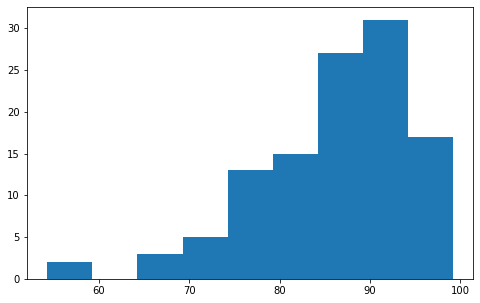

In [11]:
all_sections = GradesWithGroups(
    np.concatenate([section[1].grades, section[2].grades, section[3].grades]),
    np.concatenate([section[1].group_sizes, section[2].group_sizes, section[3].group_sizes]),
)

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(all_sections.grades, bins='auto');

The data appears to have a clear left skew and thus does not look normal (more on that below). This made wonder why the data would differ from normality in this way and if this is a typical grade distribution for an exam. I found a 2019 [paper](https://stanford.edu/~cpiech/bio/papers/gradesAreNotNormal.pdf) (citation below), in which the authors analyzed 4000 assignments graded on Gradescope and essentially determined that most of the grade distributions were too skewed to be normal. Interestingly, the skewness was usually negative, just as in our case. They found the logit-normal distribution to be a good fit for exam grade distributions.

The authors do not venture to speculate why exam grades tend to have a left skew. One guess I have is that the students with the top grades are not given the opportunity to differentiate more, by having more challenging exam questions. It is also conceivable that there is higher variability among students with lower grades for reasons beyond the specific exam design. This is all just speculation of course, but it would be interesting to investigate.

Full citation of the paper: "Grades are not Normal" by N. Arthurs, B. Stenhaug, S. Karayev, C. Piech, published in Proceedings of the 12th International Conference on Educational Data Mining, Montréal, Canada. 2019

### Residuals

We will see in the simulations at the end of this notebook that the bootstrap has very low power when the groups are small, as is the case with our data. This might be due to the fact that the bootstrap method works by taking samples from the empirical distribution function of the residuals, which might not actually be a good approximation of the actual probability distribution of the groups, due to the small sizes of the groups.

Below we visualize the empirical distribution functions of the residuals for section 10 (the results are similar for the other two sections). We also compare them to synthetic data in two scenarios:
- All groups have the same normal distribution and the group sizes are the same as in Section 1.
- All groups have the same normal distribution and there are 10 groups of size 8. (For comparison, there are 10 groups in Section 1, mostly of size 4).

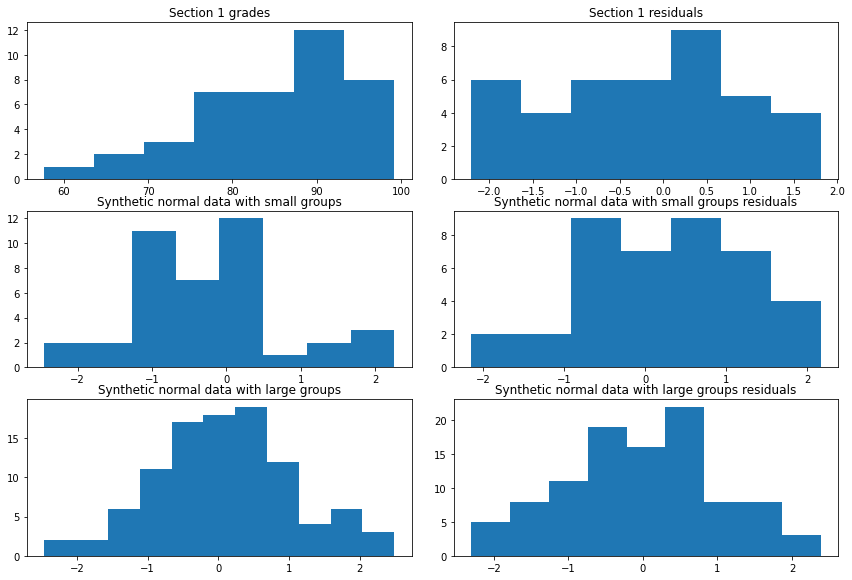

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.tight_layout()

axs[0, 0].hist(section[1].grades, bins='auto')
axs[0, 0].set_title('Section 1 grades')
axs[0, 1].hist(estimate_params(*section[1]).residuals, bins='auto')
axs[0, 1].set_title('Section 1 residuals')

synthetic_normal_small = GradesWithGroups(st.norm.rvs(size=section[1].group_sizes.sum()), section[1].group_sizes)
synthetic_normal_large = GradesWithGroups(st.norm.rvs(size=100), np.array([10] * 10))

axs[1, 0].hist(synthetic_normal_small.grades, bins='auto')
axs[1, 0].set_title('Synthetic normal data with small groups')
axs[1, 1].hist(estimate_params(*synthetic_normal_small).residuals, bins='auto')
axs[1, 1].set_title('Synthetic normal data with small groups residuals');

axs[2, 0].hist(synthetic_normal_large.grades, bins='auto')
axs[2, 0].set_title('Synthetic normal data with large groups')
axs[2, 1].hist(estimate_params(*synthetic_normal_large).residuals, bins='auto')
axs[2, 1].set_title('Synthetic normal data with large groups residuals');

The histograms seem to make clear that the empirical distributions of the residuals (pictured on the right) are not a good approximation of the underlying distribution (pictured on the left). This holds also for the synthetic data. **These small sample effects might explain the low power of the bootstrap we will observe in the simulations below and why the power of the bootstrap converges with the other tests for larger group sizes.**

### Normality

We observed that the grade distribution looks too skewed to be normal. One way to quantify this is to compute the sample skewness and sample kurtosis. Of course, we expect these two quantities to be close to 0 if the data is sampled from a normal distribution (note that by default the `scipy` kurtosis function subtracts 3 from the fourth moment, which makes the kurtosis of the normal distribution 0). We will compare them to a random normal sample of the same size as our data to get an idea of how close to 0 the sample skewness and sample kurtosis usually are.

Another common method to visualize the data to see if it looks normal is the QQ plot, where the quantiles of the sample distribution are plotted against the quantiles of the normal distribution. We will again do this for both our grades data and for comparable synthetic data from a normal distribution.

The sample skew is -1.0902692480611051 and the sample kurtosis is 1.3753992488399467.


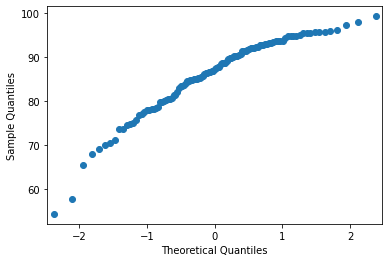

In [13]:
qqplot(all_sections.grades)
print(f'The sample skew is {st.skew(all_sections.grades)} and the sample kurtosis is {st.kurtosis(all_sections.grades)}.')

Now we compute compute the sample skew and kurtosis for a random sample of a normal distribution, as a reference for our data. We also look at the QQ plot.

The sample skew is -0.1817125808235642 and the sample kurtosis is -0.34271547675743186.


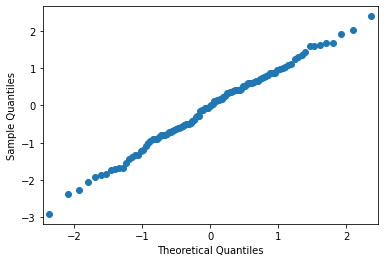

In [14]:
normal_sample = st.norm.rvs(size=110)
qqplot(normal_sample)
print(f'The sample skew is {st.skew(normal_sample)} and the sample kurtosis is {st.kurtosis(normal_sample)}.')

After running the cell above a couple of times, it is evident that a sample skew of -1 and a sample kurtosis of 1.4 are very unlikely for data sampled from a normal distribution. What this means is that the the grades distribution is skewed to the left (as we observed above) and has a longer tails than the normal distribution (a long *left* tail, really).

This can also be seen in the QQ plots, from the fact that the graph is steeper at the beginning than towards the end. For a normal sample the QQ plot is expected to be close to a line of slope 1.

For a more principled way to determine significant deviation from normality we apply the Kolmogorov–Smirnov test. This test directly measures how different the observed distribution is from the normal distribution. First it computes the maximum distance between the empirical cumulative distribution function and the cumulative distribution of the normal distribution and then it determines how extreme this distance would be if we assume that the data does come from a normal distribution. The p-value it outputs is the probability of observing a difference as large as the one observed or larger for samples from a normal distribution.

In [15]:
kstest_normal(estimate_params(*all_sections).residuals)[1]

0.044937074410551656

The deviation from normality is significant, under the usual level for significance of 0.05. Specifically, what this means is the only in 4.5% of the cases would a sample from a normal distribution lead to such an extreme difference between the distribution of the data and the underlying normal distribution. This reinforces our analysis above.

### Equal Variances

The Levene test is more suitable than than Bartlett test because the data significantly deviates from normality.

In [16]:
def test_equal_variances(pooled, group_sizes):
    groups = []
    left = 0
    for size in group_sizes:
        right = left + size
        groups.append(pooled[left:right])
        left = right
    return st.levene(*groups)[1]

for n in [1, 2, 3]:
    levene = test_equal_variances(*section[n])
    print(f'For Section {n} we have Levene p-value {levene}')

For Section 1 we have Levene p-value 0.8941346714392719
For Section 2 we have Levene p-value 0.9712056919863893
For Section 3 we have Levene p-value 0.9326385373075483


The test does not detect significant differences in the variances. However, this should be taken with a grain of salt because the groups are so small that the test probably has a very small power. One indication that the test is not working well, at least in the case of comparisons between groups within each section, is how all three p-values are so high. This is because a well-behaved test should yield p-values which are uniformly distributed under the null hypothesis and which tend to have small values under the alternative hypothesis.

## Compute p-values

In the following we compare the p-values from four hypothesis tests:
- the (non-parametric) permutation test.
- the semiparametric bootstrap.
- the (parametric) ANOVA F-test.
- the (parametric) ANOVA Welch F-test.

We use all four tests to check for significant differences between the groups in each of the three sections.

In [17]:
index = []
pvalues = {'Permutation Test': [], 'Semiparametric Bootstrap': [], 'ANOVA': [], 'ANOVA (Welch)': []}

for n in [1, 2, 3]:
    pvalues['Permutation Test'].append(permutation_test(*section[n]))
    pvalues['Semiparametric Bootstrap'].append(bootstrap_test(*section[n]))
    pvalues['ANOVA'].append(anova(*section[n], equal_vars=True))
    pvalues['ANOVA (Welch)'].append(anova(*section[n]))
    index.append(f'Section {n} Groups')

In [18]:
pd.DataFrame(pvalues, index=index)

,Permutation Test,Semiparametric Bootstrap,ANOVA,ANOVA (Welch)
Section 1 Groups,0.18275,0.36078,0.188831,0.210221
Section 2 Groups,0.05562,0.48233,0.053237,0.129899
Section 3 Groups,0.38250,0.87914,0.392885,0.851698


## Discussion

### The p-values
The first thing that jumps out at us is that the p-values of the permutation test are almost identical to the p-values of the F-test without Welch correction. In the simulations done at the end of this notebook these two tests have persistently similar p-values. While we used the same (uncorrected) F-test statistic for the permutation test, it cannot be assumed that the p-values will be so close, considering that the tests compute the p-values in very different ways: the former simply recomputed the statistic for many permutations of the data, while the latter compares the value of the statistic to a theoretical distribution (called the F-test distribution). This seems to indicate that F-test is working well despite the data not being normally distributed.

As for the statistical significance of differences in grades between the groups: Based on the permutation test (or equivalently the uncorrected F-test) alone, there are indications of a small effect, especially in Section 2, but unfortunately it is **not statistically significant**. The usual convention is to set the rejection threshold at $0.05$. Section 2 comes close but we need to consider that we made multiple comparisons (see below).

Furthermore, the results suggest that the semiparametric bootstrap has low power, probably due to the small group sizes. At the end of this notebook we investigate the size and the power of the tests with various simulations. The results there show that the bootstrap does indeed have very low power when the groups are small (such as in our data).

### Multiple Comparisons
Recall that the p-value tells us what the probability is of observing data as extreme or more extreme than the data we actually observed, *assuming the null hypothesis is true* (or perhaps an approximation of this probability). For example, according to the permutation test the probability that the distributions of the different groups in Section 2 are exactly the same is only $5.5\%$. Usually results are considered statistically significant if the p-value is under $0.05$, although this just a convention which is intended to keep the rate of false discoveries in scientific publications low (this threshold has been often criticized, as has the over-reliance on p-values more generally, but we will not get into that here).

However, that is only true for one test in isolation. Unlikely results are more likely to occur if we make multiple observations and it is very important to take this into account.

We will go through two different methods for handling so called **multiple comparisons**. To be concrete, let's say we set the significance level at $0.1$. Recall that the permutation test p-values for each of the three sections are $0.18$, $0.05$ and $0.38$.

**Bonferroni:** Divide the level $0.1$ by the number of comparisons to get the rejection threshold. In this case we would only reject the null if a p-value is under $0.1/3 = 0.0\overline{3}$. Because none of our p-values is under that threshold, we cannot reject the null in any of the three cases. This method ensures the probability of a *single* false positive will be no higher than $0.1$. The problem is that this also limits the true positives, i.e. rejections of null hypothesis which is false and should be rejected. We say that it increases the type II error rate and that it decreases the power. The next method strikes a balance between keeping false positives down while not reducing true positives too much.

**Benjamin-Hochberg:** This one is a little more involved than Bonferroni. It ensures that on average at most $10\%$ of all rejections will be false positives. Another way of putting it is that BH ensures that most of the rejections (discoveries) are in fact correct. To be clear, it does not ensure that the probability of making even a *single* type I error is at most $0.1$. In fact, BH (or variations of it) is often used in cases where thousands of comparisons are made (such as in genomics) where many true positives are expected and a small fraction of false positives is a price worth paying.

It is worth emphasizing that BH works *regardless how many of the null hypotheses tested are in fact true*. If all null hypotheses happen to be false, then of course $100\%$ of rejections will be false positives. However, BH ensures that this happens only $10\%$ of the time (if we set the level to $0.1$). Thus the *expected* false positive ratio is less than $0.1$.

Let's demonstrate BH with our p-values above. Sort the p-values: $p_{(1)} = 0.05$, $p_{(2)} = 0.18$ and $p_{(3)} = 0.38$. To find the rejection threshold using BH, we look for the largest p-value $p_{(i)}$ satifying $p_{({i})}\le 0.1\cdot i/m$ ($m$ is the number of p-values, in this case 3). To put it in words, we need the p-value not just to be bounded above by the level of the test (in this case $\alpha=0.1$), but *in addition to this* to be bounded above by a fraction of the level $\alpha$ which is equal to the fraction of p-values smaller than or equal to $p_{(i)}$. As a hypothetical example, if we had a p-value $p_{(i)}=\alpha/2$, then we could only use it as the rejection threshold if at least half of the p-values are smaller than this potential threshold $\alpha/2$. In our example, there is no such p-value because even $p_{(1)} = 0.05$ does not satisfy the condition: $0.05  > 0.1\cdot1/3$.

Actually, in this case Bonferroni and BH give similar results regardless of how we set $\alpha$ because one p-value is so much smaller than the others. If we let the level be $0.15$ both would reject one null hypothesis. We would need to raise the level all the way up to $0.27$ for BH to reject two null hypotheses and to $0.38$ for BH to reject all three. Bonferroni would reject two at $\alpha=0.54$ and there is no level at which all three would be rejected.

Such high p-values would not really be very sensible in practice, of course. It should also be made clear that the level needs to be set in advance and not adapted to the experiment. The previous paragraph is just intended to clarify the differences between the two methods.

To consider an extreme example, if all p-values happen to be less than $\alpha$, then every single hypothesis is rejected because the largest p-value would be chosen as the threshold. The main intuition behind BH is that the more concentrated the p-values from multiple tests are closer to 0, the more null hypotheses must be true (or are at least expected to be true). A logically equivalent way of saying this is that p-values would be expected to be spread out if many null hypotheses are true since p-values should be uniformly distributed (between 0 and 1) under the null hypothesis.

## Conclusions

Unfortunately, the differences in mean grades between the groups are **not statistically significant**. One of the p-values is 0.05, but taking into account the multiple comparisons we would have had to put the rejection threshold at 0.15 (this is true for Benjamin-Hochberg, not just for the more conservative Bonferroni). That threshold would be quite high. To be clear, the rejection threshold needs to be set before looking at the results for it to work as intended. The whole situation is also complicated by the fact that we did several tests. This certainly increases the likelihood of false positives but it is tricky to say by how much because the p-values of different tests are not independent of each other. We did this more as an exercise, rather than to get significant results for the group differences (it became clear early on that the group sizes are too small for significant results).

Of course, the results do not necessarily imply that there is a high probability that the group means are the same. As can be seen in the simulations below, in the more realistic scenarios all four hypothesis tests have pretty **low power**, due to the **small sample sizes**. This means that even if there were a meaningful effect it would be unlikely to be discovered by these tests (or probably *any* reasonable tests) unless it were very large. The only scenario in which the power of the tests is above $0.8$ is when we assume that the *true* group means vary as much as the sample group means (i.e. if there is a pretty large 
**effect size**).

To actually find the probability of a particular effect size in a principled way we would need to turn to **Bayesian statistics**. In a nutshell, we would need to come up with a prior (the credence we would we give to each scenario before we even look at the data) and then update this prior using the likelihood function (probability of seeing our data under each scenario). This would be an interesting direction to explore in the future.

One big takeaway is that the **semiparametric bootstrap has especially low power**, even with large effect sizes. In simulations with larger groups (size 10 specifically) the power of the bootstrap is similar to the other tests, which confirms that the small group sizes are the problem. Evidently, larger groups are needed for the bootstrap resamplings to adequately approximate the underlying distribution of the residuals. Recall that we avoided a purely nonparametric bootstrap which resamples from the individual groups because of their small sizes. We had hoped that combining the residuals of all groups using the semiparametric bootstrap would mitigate this, but this clearly failed. To salvage the bootstrap approach would need to either increase the group sizes or modify the underlying model in some way.

## APPENDIX: Simulations of Power and Size

In this last section we simulate alternative hypotheses to investigate the size and power of the three tests through simulation.

### Power and Size

The **size** of a test is easy to explain. It is simply the probability of rejecting the null hypothesis when it is in fact true. We want to keep the size as small as possible, of course. Crucially, the size is not supposed exceed the level of the test. Similarly, the **power** of a test is the probability of rejecting the null hypothesis if the alternative hypothesis is true. Just like we want to minimize the size, we also want to maximize the power and those two aims are always in tension.

To be fair, the concepts are a little trickier to make precise than the previous paragraph makes it seem. In the following two points we go into the weeds a bit more:
- The alternative hypothesis is usually defined as the logical negation of the null hypothesis, but not always. For example, if the null hypothesis is that the means of all groups are equal, then the logical negation would yield an alternative hypothesis consisting of all situations in which the means differ in any way. However, maybe we want to restrict the alternative hypothesis to include only differences in means that would be significant in a certain context (that is, maybe we are only interested in rejecting a hypothesis when there is a minimal effect size). See the [Neyman-Pearson Lemma](https://en.wikipedia.org/wiki/Neyman%E2%80%93Pearson_lemma) for an example of an alternative hypothesis which is not the negation of the null hypothesis.
- Another technicality is that both the the null hypothesis and the alternative hypothesis usually are usually composite hypotheses, meaning that they don't simply say that the data comes from a specific probability distribution, but rather from a set of possible probability distributions. For example, if the null hypothesis is that the means of the groups are equal, that doesn't fully determine the probability distribution at all. In truth, the size of a test is the supremum (which can be roughly thought of as the maximum) of the probability to reject the null hypothesis under a specific probability distribution which is part of the null hypothesis, where the supremum is taken over all those probability distributions. The same thing goes for the power and the alternative hypothesis.

In the simulations we can't consider all scenarios and take the supremum to actually compute the power and size over the whole space of possibilities. Instead, we will contemplate some realistic scenarios for our situation. We do this by drawing samples from probability distributions which seem reasonable models for our data, apply our tests and finally inspect the distribution of the resulting p-values. If the tests work well, they will be uniformly distributed whenever the null hypothesis is true and concentrated towards small values when the null hypothesis is false.

### Simulations Setup

In all simulations we will assume that the grade distributions have the same "shape" for all groups, meaning that they are the same up to shifting and scaling. We will use both the empirical distribution function (ECDF) of the pooled grades and the normal distribution.

Beyond this, the three parameters we can tune are the means, variances and group sizes. We will consider cases in which the true group means are equal, differ slightly and differ strongly. Similarly, we will consider cases in which the true group variances are equal, differ slightly or differ strongly. Finally, we will do simulations with small group sizes and with large group sizes. Specifically, we will use the exact group sizes of Section 1 (which happens to have 10 groups) or 10 groups of size 10.

All in all, there are 36 possible scenarios. To avoid clutter we will only include a subset of those. That will allow us to compute thousands of p-values in each case, which can take a long time because we are doing  bootstrap and permutation resamplings.

To ensure the simulations are relevant to our actual grades data, we use the sample group means and sample group standard deviations.
- Constant mean and variance: median group mean and average group variance over all groups from all three sections.
- Weakly varying means and variances: a random sample of 10 out of middle $33\%$ of the group means and group variances over all groups (i.e. excluding the top third and bottom third).
- Strongly varying means and variances: a random sample of 10 out of middle $80\%$ of the group means and group variances over all groups (i.e. excluding the top $10\%$ and bottom $10\%$).
- Extremely varying means: a random sample of 10 among all group means.

### Simulation Results Overview

**All tests have low power, especially the bootstrap:** As we had anticipated above, the semiparametric bootstrap has a very low power when the groups are small (around size 4, as is the case in our data). It does similarly to the other tests when we increase the group size to 10. Something else we see in the simulations is that all the tests have low power, unless we let the group means vary a lot.

**How much the true means vary matters a lot:** In the following we assume that the group standard deviations are equal.
- For weakly varying means (chosen from middle $33\%$ of sample group means, ranging from $85.0$ to $87.4$) the rejection rate is $7\%$, almost the same as under the null hypothesis.
- For strongly varying means (chosen from middle $80\%$ of sample group means, ranging from $82.8$ to $90.2$) the rejection rate is $17\%$, which is still way too low.
- For very strongly varying means (chosen from $100\%$ of sample group means, ranging from $73.6$ to $92.5$) the rejection rate is  $85\%$, which is reasonable.

**Poor performance of the Welch F-test:** It is surprising (at least to me) that the uncorrected F-test did better than the Welch F-test, considering that it is widely recommended to use the Welch test in all circumstances. Especially considering that we violated the normality and equal variances assumptions of the F-test and we have unequal group sizes, which is precisely when the Welch F-test should be doing better. My guess is that the Welch correction is not working well with the very small groups in our data. For larger groups it does better.

**The group sizes are very important:** Unsurprisingly, increasing the group sizes to 10 increases the power of all tests significantly. This is especially the case for the bootstrap test.

**Close enough to normal**: Even though the empirical distribution function is too skewed to be normal, it seems to be close enough for the F-tests. In the simulations it made almost no difference whether we used the empirical distribution or the normal distribution (not all simulations are included below).

**Bimodal p-value distributions:** Interestingly, when we have equal means and let the group standard deviations vary strongly, the p-value distributions for the permutation test and uncorrected F-test become *bimodal*: there is a peak at 0 and a peak at 1. The peak at 0 corresponds to samples with very small variation between sample group means (the groups form one big cluster), while the peak at 1 corresponds to sampled with very large variation between sample group means (the groups are spread into separate clusters). Remember that this case (equal means and unequal variances) is *not* included in the null hypothesis for the permutation test. It also violates the assumptions of the non-corrected F-test (ANOVA). Thus, a uniform p-value distribution was definitely not expected in those cases. What we might have expected for the permutation test is that the p-value distribution has only one peak, namely at 0. However, the statistic we used in the permutation test (the F-test statistic) is meant to capture differences between group *means*, not group *standard deviations*. This is presumably why we see this double peak and consequent low power. The bootstrap test and the Welch F-test did not result in bimodal p-value histograms in any of our simulations. For large group sizes the p-values are close to uniformly distributed and the rejection rate is close to the level. This is as it should be because the former are precisely **designed to handle variation in the standard distributions**.

### Simulation Results

First we need to compute the group means and standard deviations, as well as the empirical distribution, to be used in the simulations below.

The median of the group means is 86.5875 and the median of the group standard deviations is 6.331982950879348.


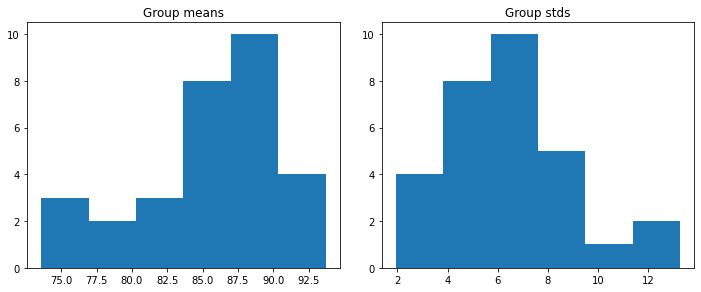

In [20]:
all_group_means = take_group_means_and_vars(*all_sections).group_means
all_group_stds = np.sqrt(take_group_means_and_vars(*all_sections).group_vars)
central_mean = np.median(all_group_means)
central_std = np.median(all_group_stds)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.tight_layout()
ax1.hist(all_group_means, bins='auto')
ax1.set_title('Group means')
ax2.hist(all_group_stds, bins='auto')
ax2.set_title('Group stds')

print(f'The median of the group means is {central_mean} and the median of the group standard deviations is {central_std}.')

In [21]:
section1_group_sizes = section[1].group_sizes
section1_n_groups = section1_group_sizes.size
large_group_sizes = np.array([10] * section1_n_groups)

# Truncated lists of group means and group stds
total_number_of_groups = all_group_means.size
third_group_means = np.sort(all_group_means)[total_number_of_groups // 3: 2 * total_number_of_groups // 3]
third_group_stds = np.sort(all_group_stds)[total_number_of_groups // 3: 2 * total_number_of_groups // 3]
most_group_means = np.sort(all_group_means)[total_number_of_groups // 10: 9 * total_number_of_groups // 10]
most_group_stds = np.sort(all_group_stds)[total_number_of_groups // 10: 9 * total_number_of_groups // 10]

# Sample of means and stds for use in the simulations
rng = np.random.default_rng(42)

constant_means = np.array([central_mean] * section1_n_groups)
constant_stds = np.array([central_std] * section1_n_groups)
weakly_varying_means = rng.choice(third_group_means, size=section1_n_groups)
weakly_varying_stds = rng.choice(third_group_stds, size=section1_n_groups)
strongly_varying_means = rng.choice(most_group_means, size=section1_n_groups)
strongly_varying_stds = rng.choice(most_group_stds, size=section1_n_groups)
very_strongly_varying_means = rng.choice(all_group_means, size=section1_n_groups)

# Normalized empirical distribution
normalized_ecdf = (all_sections.grades - all_sections.grades.mean()) / all_sections.grades.std()

Finally, we write two functions for the simulations to do the following:
- Draw samples from some given group distributions and compute the p-value distributions of each hypothesis test.
- Plot the p-value histograms for all the tests in a grid.

In [22]:
def simulate_pvalues(group_sizes, group_means, group_stds, dist, n_sims, level):
    '''Take n_sims samples with distribution dist and the given group means, group variances
    and group sizes. For each sample, compute the p-value for each of the four hypothesis tests.
    '''
    coverage, pvalues = defaultdict(int), defaultdict(list)
    rng = np.random.default_rng()
    for _ in tqdm(range(n_sims)):
        group_samples = []
        for size, mean, std in zip(group_sizes, group_means, group_stds):
            if isinstance(dist, np.ndarray):
                # dist is the normalized ECDF
                sample = mean + rng.choice(dist, size) * std
                group_samples.append(sample)
            elif dist == 'normal':
                sample = st.norm.rvs(loc=mean, scale=std, size=size, random_state=rng)
                group_samples.append(sample)
            else:
                raise Exception(f'Invalid dist argument: {dist}')
        pooled_sample = np.concatenate(group_samples)
        
        pvalue = permutation_test(pooled_sample, group_sizes, n_resample=10**4)
        pvalues['permutation'].append(pvalue)
        coverage['permutation'] += pvalue <= level
        
        pvalue = bootstrap_test(pooled_sample, group_sizes, n_resample=10**4)
        pvalues['bootstrap'].append(pvalue)
        coverage['bootstrap'] += pvalue <= level
        
        pvalue = anova(pooled_sample, group_sizes, equal_vars=True)
        pvalues['ANOVA'].append(pvalue)
        coverage['ANOVA'] += pvalue <= level
        
        pvalue = anova(pooled_sample, group_sizes)
        pvalues['ANOVA (Welch)'].append(pvalue)
        coverage['ANOVA (Welch)'] += pvalue <= level
        
    for key in coverage:
        coverage[key] /= n_sims
    
    return coverage, pvalues

In [23]:
def plot_histograms(pvalues_dict):
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
    for position, key in zip(positions, pvalues_dict):
        axs[position].hist(pvalues_dict[key], bins='auto')
        axs[position].set_title(key)

#### Groups Have Equal Distributions

In the following we simulate the case in which the grade distributions are exactly the same for all groups.

This is precisely the null hypothesis of the permutation test and it is contained in the null hypothesis of the other two tests (equal means). Therefore, we would expect the p-values to be uniformly distributed if the tests are working well.

We start with the **normal distribution**, which satisfies the assumptions of the F-test.

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.0463
bootstrap        0.0110
ANOVA            0.0469
ANOVA (Welch)    0.1073
dtype: float64

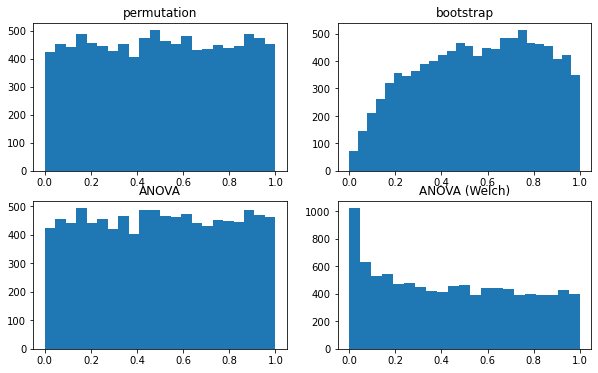

In [24]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(section1_group_sizes, constant_means, constant_stds, 'normal', n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

Firstly, the permutation test and the uncorrected F-test (ANOVA) have almost identical p-values and they are also performing the best by far. Their rejection rates are just under the level $0.05$, which is perfect. The distributions look uniformly distributed.

The p-values for the semiparametric bootstrap and the Welch corrected F-test are clearly not uniformly distributed.

For the bootstrap the actual size turns out to actually be smaller than the level. This is not in itself undesirable but it indicates that the power will be very low.

Let's see if the bootstrap and Welch F-test do better for **larger groups**:

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.0474
bootstrap        0.0428
ANOVA            0.0475
ANOVA (Welch)    0.0578
dtype: float64

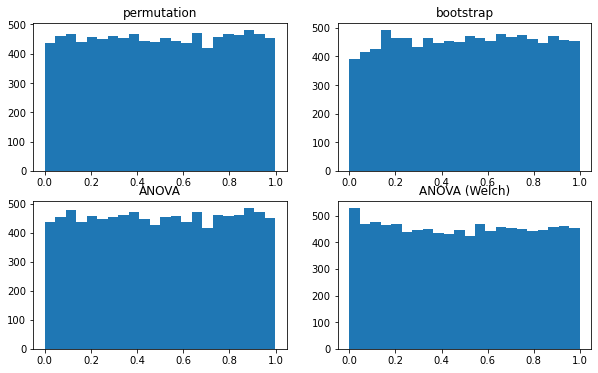

In [25]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(large_group_sizes, constant_means, constant_stds, 'normal', n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

From what we have seen above, it seems that the bootstrap and Welch F-test are not performing well for the small group sizes present in our data (around 4), while doing reasonably well for size 10 groups. The permutation test and the regular uncorrected F-test (one-way ANOVA) are still the best but not by much.

Next, let's use the actual **empirical grades distribution** instead of the normal distribution.

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.0551
bootstrap        0.0127
ANOVA            0.0543
ANOVA (Welch)    0.1454
dtype: float64

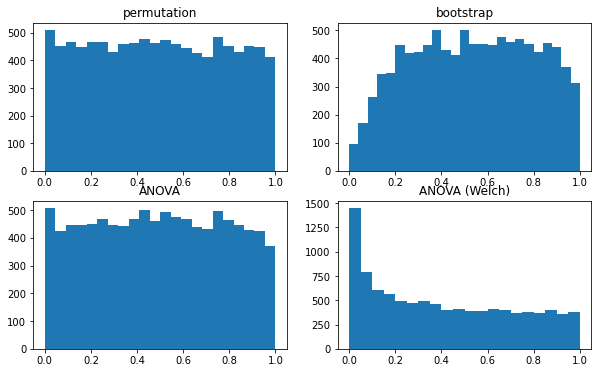

In [37]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(section1_group_sizes, constant_means, constant_stds, normalized_ecdf, n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

Now let's make the groups larger again.

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.0486
bootstrap        0.0499
ANOVA            0.0480
ANOVA (Welch)    0.0758
dtype: float64

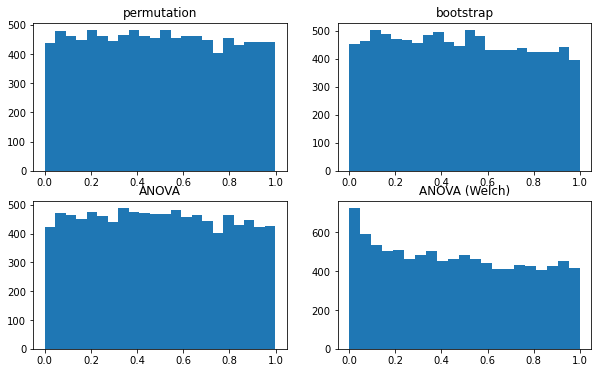

In [27]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(large_group_sizes, constant_means, constant_stds, normalized_ecdf, n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

We can see that the empirical distribution and the normal distribution yield pretty results. The biggest difference is for the Welch F-test, which has an even worse rejection rate for the empirical distribution. This might be due to the long left tail. **We will only use the empirical distribution function from now on.**

#### Groups Have Equal Means but Varying Standard Deviations

Now we are strictly speaking stepping out of the null hypothesis of the permutation test, which requires standard deviations to be equal too (although the statistic we chose makes it mostly sensitive to the means). We are still within the null hypothesis of the other tests. Again, we would expect uniformly distributed p-values if the tests are working as they should.

First let us **vary the standard deviations only slightly**.

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.0512
bootstrap        0.0145
ANOVA            0.0509
ANOVA (Welch)    0.1438
dtype: float64

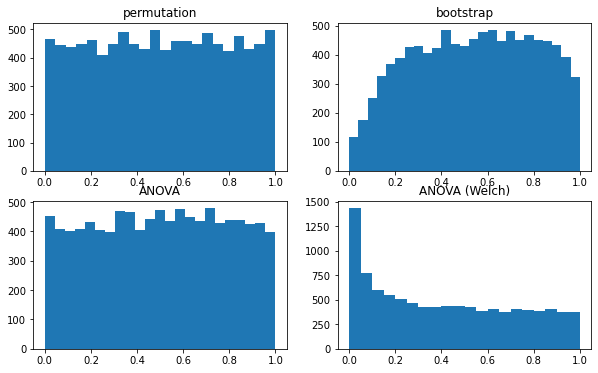

In [28]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(section1_group_sizes, constant_means, weakly_varying_stds, normalized_ecdf, n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

The p-values are almost identical to the case with constant standard deviation. They are very slightly larger in this case (as was expected) but not significantly. The same is true for **larger group sizes**:

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.0493
bootstrap        0.0508
ANOVA            0.0472
ANOVA (Welch)    0.0730
dtype: float64

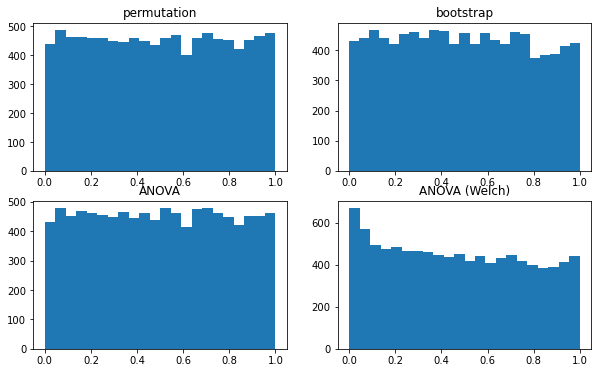

In [29]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(large_group_sizes, constant_means, weakly_varying_stds, normalized_ecdf, n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

If we let the **standard deviation vary strongly** between the groups something interesting happens: some p-value distributions have a peak at 1 as well as the usual peak at 0. This is the case also for very large group sizes. For instance, we let the groups be of size 50 below, which is much larger than the groups we have been considering. The peaks do not seem to change much as we vary the group sizes from 4 to 10 to 50.

When the groups are this large and the group standard deviations differ strongly the bootstrap and the Welch F-test do better than the permutation test and regular F-test. This is as it should be because the former are precisely designed to handle variation in the standard distributions. It is worth noting that this is the only case in which the bootstrap and the Welch F-test seem to be doing better than the other two, assuming our goal is to detect differences in means (which, to be fair, is not really the aim of the permutation test).

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.0672
bootstrap        0.0174
ANOVA            0.0654
ANOVA (Welch)    0.1576
dtype: float64

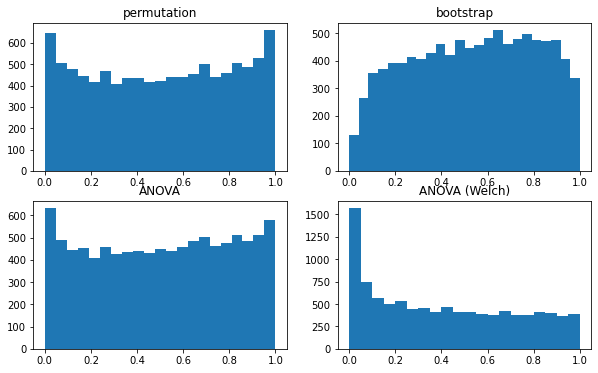

In [30]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(section1_group_sizes, constant_means, strongly_varying_stds, normalized_ecdf, n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.0679
bootstrap        0.0535
ANOVA            0.0680
ANOVA (Welch)    0.0598
dtype: float64

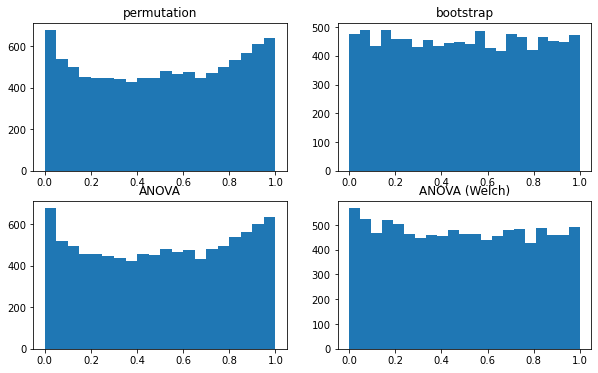

In [31]:
n_sims = 10**4
level = 0.05

very_large_group_sizes = np.array([50] * 10)

result = simulate_pvalues(very_large_group_sizes, constant_means, strongly_varying_stds, normalized_ecdf, n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

#### Unequal means

Finally, we have arrived at the arguably more important alternative hypothesis: there is a difference in the **expected grade** (mean) of the groups.

First, we will assume that the **means vary weakly** to see if the tests would pick up on that. Later, we will let the means vary more strongly.

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.0727
bootstrap        0.0185
ANOVA            0.0715
ANOVA (Welch)    0.1585
dtype: float64

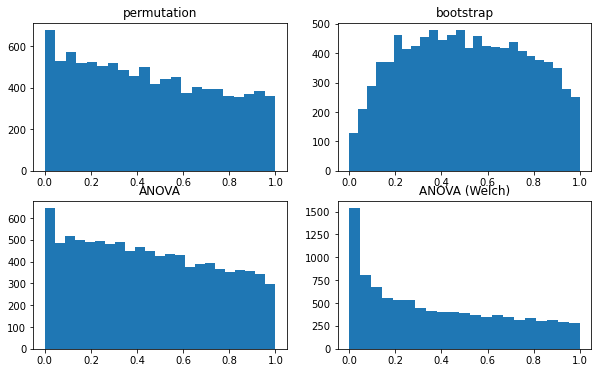

In [32]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(section1_group_sizes, weakly_varying_means, constant_stds, normalized_ecdf, n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

We see that the tests are very weak in this case, due to the small effect size (weakly varying means) and the small group sizes. The bootstrap is still performing terribly and the permutation tests and ANOVA rejection rates are barely higher than the level of the test.

The Welch F-test has the highest power, but this is useless given that the rejection rate is pretty much the same as it was when the null hypothesis was true (making it impossible to distinguish between true and false positives).

Let's see if the power increases with larger group sizes:

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.1241
bootstrap        0.1120
ANOVA            0.1218
ANOVA (Welch)    0.1531
dtype: float64

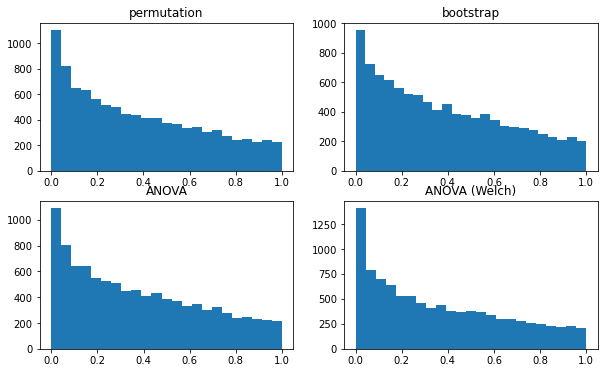

In [33]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(large_group_sizes, weakly_varying_means, constant_stds, normalized_ecdf, n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

Leaving the Welch F-test aside, the power has increased for larger groups, but it is still not great. It is worth noting that the bootstrap now yields almost the same p-value distribution as the permutation test and regular F-test, underscoring how the bootstrap does fine for larger groups, but just can't deal with the small groups in our data.

Next we will let the **group means vary strongly**. Recall that we randomly picked 10 the means from the middle $80\%$ sample group means.

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.1710
bootstrap        0.0329
ANOVA            0.1704
ANOVA (Welch)    0.2581
dtype: float64

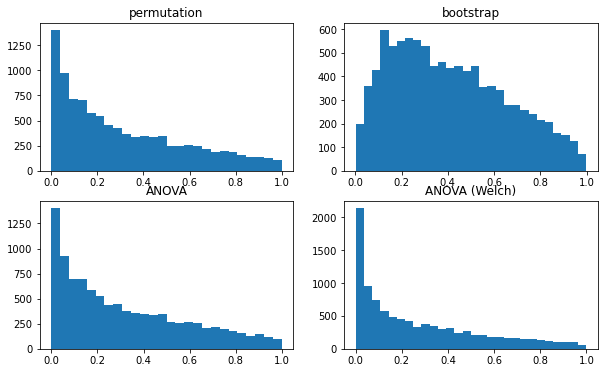

In [34]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(section1_group_sizes, strongly_varying_means, constant_stds, normalized_ecdf, n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.4901
bootstrap        0.3989
ANOVA            0.4847
ANOVA (Welch)    0.4882
dtype: float64

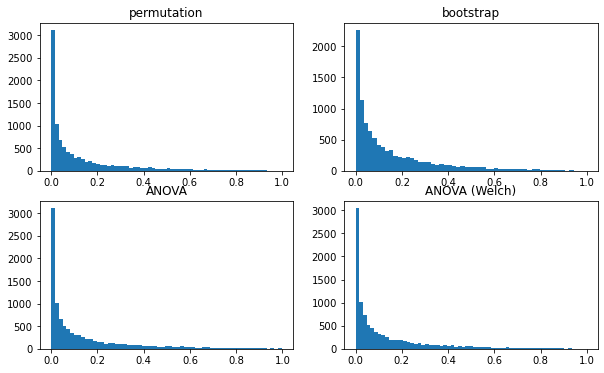

In [36]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(large_group_sizes, strongly_varying_means, constant_stds, normalized_ecdf, n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

As we can see, going from the middle $33\%$ group means to the middle $80\%$ group means made an enormous difference. At around $0.4$, the power is still not great.

One way to increase the power is increasing the effect size even more. In the following, we will randomly choose from $100\%$ of the group means (what we called very strongly varying means).

  0%|          | 0/10000 [00:00<?, ?it/s]

permutation      0.8508
bootstrap        0.2242
ANOVA            0.8502
ANOVA (Welch)    0.7863
dtype: float64

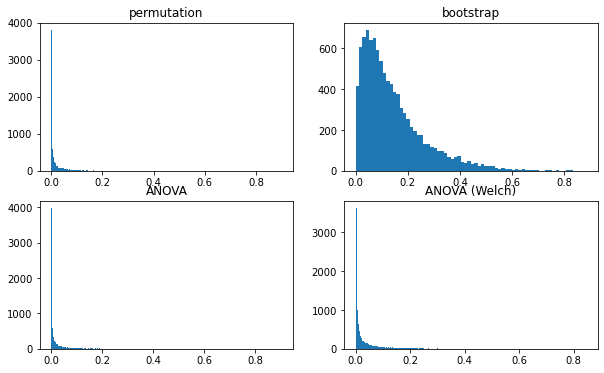

In [35]:
n_sims = 10**4
level = 0.05

result = simulate_pvalues(section1_group_sizes, very_strongly_varying_means, constant_stds, normalized_ecdf, n_sims, level)
plot_histograms(result[1])
pd.Series(dict(result[0]))

We see that in the extremely varying means scenario the power of all tests other than the bootstrap is reasonably good ($0.85$). Surprisingly, the Welch corrected F-test has a lower power that the uncorrected F-test in this case, even though in most other cases it had a higher power (even *too* high, for equal means).